##Домашнее Задание (1)

###1. Получить точность 97.5% на валидации MNIST.

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [30]:
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    # nn.Dropout(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32,10),
    nn.LogSoftmax(dim=1)
)

In [24]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

0.9661666666666666 0.9631
0.9769833333333333 0.9698
0.9785333333333334 0.9676
0.98085 0.9693
0.9867833333333333 0.9735
0.9901833333333333 0.9754
0.9886 0.9764
0.9909666666666667 0.9763
0.9898666666666667 0.9794
0.9917833333333334 0.9786
0.9940833333333333 0.9787
0.99065 0.9774
0.9905166666666667 0.9754
0.99235 0.9761
0.99335 0.976
0.9939166666666667 0.9794
0.9941666666666666 0.9781
0.99425 0.9782
0.9966 0.9796
0.9971166666666667 0.9808


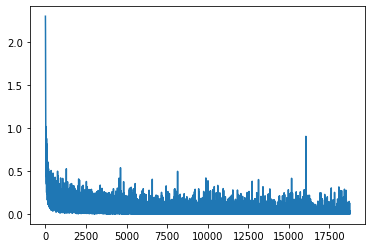

In [32]:
train_losses = []
for epoch in range(20):
    for X, y in train:
        X = X.view(-1, 784)  # разгладим картинку в вектор
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())
       
        
        optimizer.step()
    
    print(accuracy(model, train), accuracy(model, val))
        
plt.plot(train_losses)
plt.show()

In [34]:
# Результат на валидации
print(f'val result: {accuracy(model, val)}')

val result: 0.9808


### 2. Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).

In [53]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 100),
        )
        
        self.decode = nn.Sequential(
            # а теперь наоборот - из Х-мерного в картинку
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters())

In [54]:
for epoch in range(20):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0387
epoch 1, loss 0.0180
epoch 2, loss 0.0133
epoch 3, loss 0.0109
epoch 4, loss 0.0095
epoch 5, loss 0.0085
epoch 6, loss 0.0077
epoch 7, loss 0.0072
epoch 8, loss 0.0067
epoch 9, loss 0.0064
epoch 10, loss 0.0060
epoch 11, loss 0.0058
epoch 12, loss 0.0055
epoch 13, loss 0.0053
epoch 14, loss 0.0052
epoch 15, loss 0.0050
epoch 16, loss 0.0048
epoch 17, loss 0.0047
epoch 18, loss 0.0046
epoch 19, loss 0.0045


In [55]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [56]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

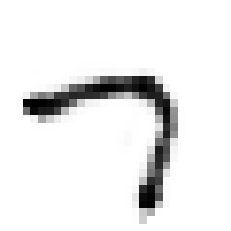

In [60]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

### 3. Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

In [61]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
        
        self.decode = nn.Sequential(
            # а теперь наоборот - из Х-мерного в картинку
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters())

In [62]:
for epoch in range(20):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0597
epoch 1, loss 0.0494
epoch 2, loss 0.0459
epoch 3, loss 0.0437
epoch 4, loss 0.0425
epoch 5, loss 0.0417
epoch 6, loss 0.0410
epoch 7, loss 0.0405
epoch 8, loss 0.0401
epoch 9, loss 0.0397
epoch 10, loss 0.0394
epoch 11, loss 0.0392
epoch 12, loss 0.0390
epoch 13, loss 0.0387
epoch 14, loss 0.0384
epoch 15, loss 0.0382
epoch 16, loss 0.0381
epoch 17, loss 0.0379
epoch 18, loss 0.0378
epoch 19, loss 0.0377


In [91]:
df = pd.DataFrame(columns=['x', 'y', 'target'])
for data, y in train:
        data = data.view(-1, 784)
        s = model.encode(data)
        b = {'x': s.T[0].tolist(), 'y': s.T[1].tolist(), 'target': y.tolist()}
        df_b = pd.DataFrame(b)
        df = pd.concat([df, df_b])

In [92]:
df.head()

,x,y,target
0,-0.741580,-7.153258,2
1,2.973727,3.742310,0
2,-4.830573,6.812680,4
3,-0.230504,0.272080,8
4,-0.609224,0.960369,5


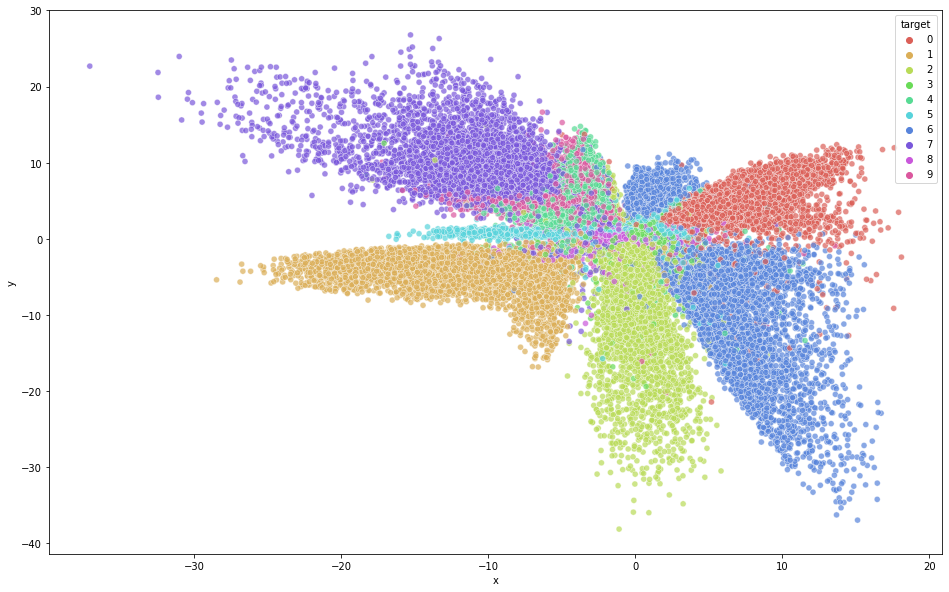

In [95]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="target",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7
)

#### Посмотрим на то как наш автоэнкодер восстанавливает информацию после сжатия

In [164]:
x, y = next(iter(train))

1. Картинка на начальных данных

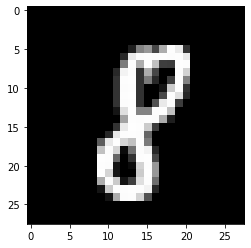

In [165]:
first_image = numpy.array(x[0][0].tolist(), dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

2. Картинка на данных после кодирования и декодирования

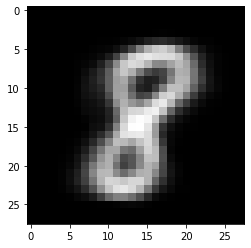

In [166]:
first_image_de = numpy.array(model(x[0][0].view(1,784)).tolist(), dtype='float')
pixels = first_image_de.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()